In [ ]:
import sys
sys.path.append("/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz")
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import random
import csv
from pathlib import Path
from IPython.display import clear_output

from Python.utils.utils import extract_segmentation_slices

In [ ]:
SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud"
MHA_SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud/correct_mha_filtered"
NRRD_SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud/correct_seg_nrrd_filtered"

In [ ]:
IMAGE_DIR = "/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz/Data/COMPLETE_DATA/all_classes/unified_resolution/images"
LABEL_DIR = "/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz/Data/COMPLETE_DATA/all_classes/unified_resolution/labels"

images = [os.path.join(IMAGE_DIR, image) for image in os.listdir(IMAGE_DIR)]
labels = [os.path.join(LABEL_DIR, label) for label in os.listdir(LABEL_DIR)]

for image, label in zip(images, labels):
    masks = [os.path.join(label, mask) for mask in os.listdir(os.path.join(label))]
    seg_channels = []
    indices = []
    seg_arrs = []

    for i, mask in enumerate(masks):
        im = sitk.ReadImage(mask)
        im_data = sitk.GetArrayFromImage(im).squeeze().squeeze()

        if len(np.unique(im_data)) > 1:
            seg_channels.append(i)
            indices.append(extract_segmentation_slices(im_data))
            seg_arrs.append(im_data)
        
        number_of_channels = len(seg_channels)

    image_to_view = sitk.ReadImage(image)
    image_arr = sitk.GetArrayFromImage(image_to_view).squeeze().squeeze()
    
    fig, axs = plt.subplots(number_of_channels, 2)
    try:
        # print(image_arr.shape)
        # print(seg_arrs[0].shape)
        for i in range(len(axs)):
            k = random.choices(indices[i], k=2)
            axs[i][0].imshow(image_arr[k[0]], cmap='gray')
            axs[i][0].imshow(seg_arrs[i][k[0]], alpha=0.3)
            axs[i][1].imshow(image_arr[k[1]], cmap='gray')
            axs[i][1].imshow(seg_arrs[i][k[1]], alpha=0.3)
        plt.show()
        uinput = input()
        clear_output(wait=True)
    except:
        print(image_arr.shape)
        print(seg_arrs[0].shape)
        k = random.choices(indices[i], k=2)
        axs[0].imshow(image_arr[k[0]], cmap='gray')
        axs[0].imshow(seg_arrs[i][k[0]], alpha=0.3)
        axs[1].imshow(image_arr[k[1]], cmap='gray')
        axs[1].imshow(seg_arrs[i][k[1]], alpha=0.3)
        plt.show()
        uinput = input()
        clear_output(wait=True)
    

    
    


### Co udało się zrobić:
1. Data mining:
- Ogólny opis całego dostępnego datasetu, zawierane klasy
- Odsortowanie niepotrzebnych plików
- Wyodrębnienie koniecznych metadanych opisujących segmentację
- Przygotowanie skryptów eksplorujących zbiór danych
- Przygotowanie statystyk: ilość danych oznaczonych, ilość danych nieoznaczonych, ilość wystąpień każdej z klas (chorób) na danych oznaczonych
- Zliczanie objętości różnych klas na pojedynczym zdjęciu w pikselach
2. Wizualizacja wyników
- Przygotowanie skryptu do automatycznej generacji wizualizacji dla zadanego przypadku, z możliwością dodania własnych oraz automatycznych komentarzy, zapisywanych do pliku CSV
- Finalne wizualne sprawdzenie kompatybilności obrazów z segmentacjami w oparciu o próbę losową
- Przygotowanie pliku z krótkimi komentarzami odnoszącymi się do wielkości oznaczonych obszarów na zdjęciach
### Co jest jeszcze do zrobienia:
- Zliczanie objętości w wokselach
- Po konsultacji - możliwość pogrupowania klas między sobą np "mass", "node" itp
- Opis dotychczasowych prac w Overleafie
- nnUNet - poczytać w kategoriach wykorzystania w oparciu o odpowiednio przygotowane dane
- skrypt do automatycznego odsiewu wadliwych danych, sprawdzający:
    * czy obraz zawiera jakąkolwiek segmentację
    * czy wszystkie zaznaczone segmentacje faktycznie występują (ilość unikatowych wartości pikseli w segmentacji w stosunku do ilości rodzajów segmentacji)
    * czy między zdjęciem a segmentacją zgadza się space origin, rotacja (?), offset(?)

In [1]:
import sys
sys.path.append("/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz")

import torch
import torchio as tio
import os
import matplotlib.pyplot as plt
import time
import wandb

from monai.losses import DiceLoss
from monai.networks.nets import Unet
from monai.networks.layers import Norm
from torch.utils.data import DataLoader

from Core.datasets import get_datasets

/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz/Data/COMPLETE_DATA/all_classes/unified_resolution"

IMAGE_DIR = os.path.join(DATA_ROOT, "images")
LABEL_DIR = os.path.join(DATA_ROOT, "labels")
CSV_DIR = os.path.join(DATA_ROOT, "csv")

TRAIN_CSV_PATH = os.path.join(CSV_DIR, "train.csv")
VALIDATION_CSV_PATH = os.path.join(CSV_DIR, "validation.csv")
TEST_CSV_PATH = os.path.join(CSV_DIR, "test.csv")

ORIGINAL_CLASSES = ['axillary lymph node',
           'sternal lymph node',
           'hepatic mass',
           'lung consolidation',
           'lipoma',
           'subcutaneous mass',
           'lung mass',
           'interstitial pattern']

CUSTOM_CLASSES = [
    'unidentified node'
]

CLASSES = ORIGINAL_CLASSES + CUSTOM_CLASSES

PREPROCESSING_TRANSFORMS = tio.Compose([
        tio.Clamp(out_min = -2000, out_max=4000),
        tio.RescaleIntensity((0, 1))
    ])

AUGMENTATION_TRANSFORMS = tio.Compose([
        tio.RandomFlip(p=0.8),
        tio.RandomAffine(),
        tio.RandomGamma(p=0.75),
        tio.RandomNoise(p=0.75),
        tio.RandomMotion(degrees=10, translation=10, p=0.5),   # może być długie
    ])

MODEL_NAME = "24-08-BASIC-001"

BATCH_SIZE = 1
LR = 1e-3

NUM_EPOCHS = 100

device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

train, validation = get_datasets(
    image_dir = IMAGE_DIR,
    label_dir = LABEL_DIR,
    classes = CLASSES,
    train_csv_path = TRAIN_CSV_PATH,
    validation_csv_path = VALIDATION_CSV_PATH,
    test_csv_path = TEST_CSV_PATH,
    preprocessing_transforms = PREPROCESSING_TRANSFORMS,
    augmentation_transforms = None,
    patch_based=False
)

train_dataloader = DataLoader(
    dataset = train, 
    batch_size = BATCH_SIZE, 
    shuffle = True,
    num_workers=0)
validation_dataloader = DataLoader(
    dataset = validation, 
    batch_size = BATCH_SIZE, 
    shuffle = True,
    num_workers=0)

model = Unet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = len(CLASSES),
    channels = (8, 16, 32, 64, 128, 256),
    strides = (2,2,2,2,2),
    num_res_units = 4,
    norm = Norm.INSTANCE
).to(device)

loss_fcn = DiceLoss(sigmoid=True)
opt = torch.optim.Adam(model.parameters(), LR)

Using cuda:1 device


Plaèko,Ðjurða_Piki.mha
tensor(-2000.)
tensor(3000.)


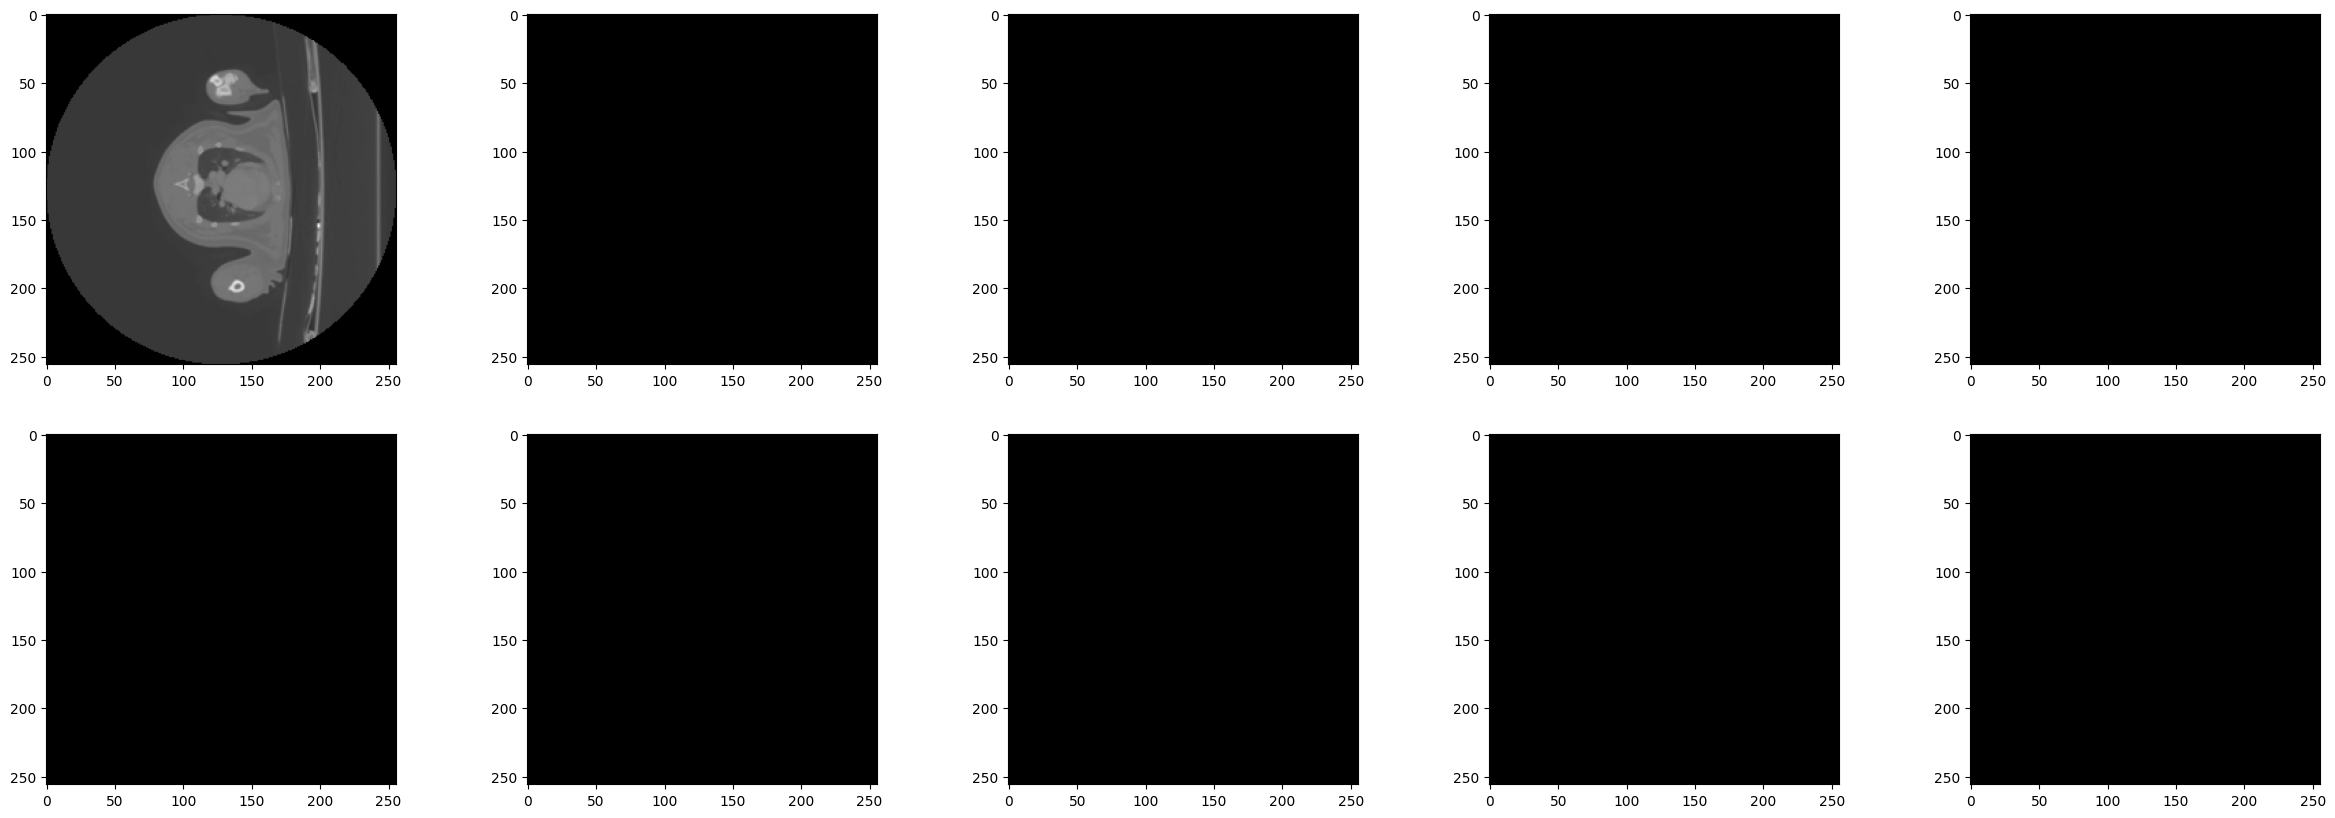

In [4]:
inputs, labels = next(iter(validation_dataloader))
fig, axs = plt.subplots(2, 5, figsize=(30,10))
print(torch.min(inputs))
print(torch.max(inputs))
# print(np.min(inputs))
# print(np.max(inputs))
axs[0][0].imshow(inputs[0,0,:,:,127], cmap="gray")
axs[0][1].imshow(labels[0,0,:,:,127], cmap="gray")
axs[0][2].imshow(labels[0,1,:,:,127], cmap="gray")
axs[0][3].imshow(labels[0,2,:,:,127], cmap="gray")
axs[0][4].imshow(labels[0,3,:,:,127], cmap="gray")
axs[1][0].imshow(labels[0,4,:,:,127], cmap="gray")
axs[1][1].imshow(labels[0,5,:,:,127], cmap="gray")
axs[1][2].imshow(labels[0,6,:,:,127], cmap="gray")
axs[1][3].imshow(labels[0,7,:,:,127], cmap="gray")
axs[1][4].imshow(labels[0,8,:,:,127], cmap="gray")
plt.show()